# Monte Carlo Search for Better Initial Conditions

In modeling, there is a method known as the _Monte Carlo Hypercube_. For effective use of a hypercube, one needs to have a search space that is too large to iterate through, and potentially too many outputs to monitor individually. A hypercube allows you to draw correlations between large amounts of parameters and outputs using far fewer iterations and tests than would otherwise be necessary.

It accomplishes this feat through the magic of random numbers. By selecting random items over the search space, it becomes possible to create enough data to interpolate relevant results representative of the average without strong testing. An implicit assumption of the hypercube is that the search space is continuous; if it is discontinuous, errors and nonlinearities will pop up in the output data. 

However, these neural networks are, thankfully, a fully linear and continuous system. (If it were not, the gradient of the cost would be discontinuous. There are systems for which that is the case, but this is not one of them.)

What follows is a brief discussion on the oddities that result from hypercube searching.

In [1]:
# Let's just get these out of the way...
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import cm
from IPython.html.widgets import interact
import pickle

from dataset_mgmt import *
from nnet_core import *
from transfer_funcs import *

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
# Data has been pregenerated (it takes a few hours - reduced from a week)
dataset = pickle.load(open('single_layer_evaluation.pickle', 'rb'))

data_names = ('Net Quantity', 'Net Keep Qty', 'Learning Rate', 'Weight Decay Rate',  
         'First Layer Nodes', 'Second Layer Nodes', 'Learning Epochs', 
         'Training Set Size', 'Training Batch Size', 'Effectiveness')

for name in data_names:
    dataset[name] = [x for y,x in sorted(zip(dataset['Effectiveness'], dataset[name]))[::-1]]

The following interactive plot shows how all the tested parameters compare against the network effectiveness. There are a few notable results that come out of this plot.

The most significant result is that the neural network tuning paramets must all be inter-related. No matter which plot is selected, it is _possible_ to create high success rates no matter the value. An averaging plot later will show more information on this. 

Two parameters were additionally tested: a number of networks created in a random forest, and a number of networks selected out of this pool. More information on this is available in [NNet Averaging](NNet_Averaging.ipynb). However, the plot of the network keep quantity ($m$ in the averaging notebook) versus effectiveness seems to corroborate the claim the other notebook notes that the more networks are kept, the greater chance the network will have a higher accuracy. 

The plot of learning rate versus effectiveness seems to be scattered evenly - there are high accuracy networks with low learning rates, and low accuracy networks with high learning rates. This suggests that the learning rate is less relevant than the number of epochs and/or other parameters, but further topological classification methods would be necessary to discern which parameters are relevant to this plot. 

Similarly, the number of nodes also seems less relevant - to a point. The highest value seems to drop the closer to zero the network goes, which is predictable. Past that, the plot is unclear - further data analysis as presented below shows better results. The same result shows for learning epochs and training set size, though training set size has a clearer relationship. By way of contrast, batch size seems to have a negative relationship.

<function __main__.create_plot>

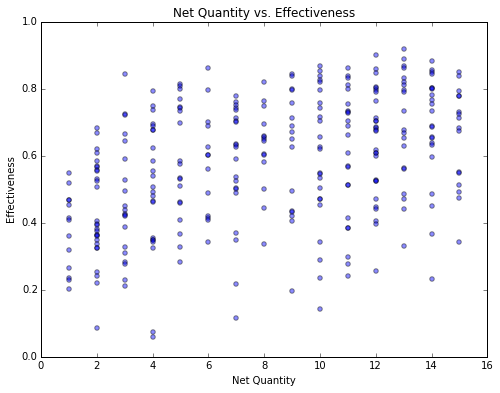

In [3]:
def create_plot(dataname):
    plt.scatter(dataset[dataname], dataset['Effectiveness'], alpha=0.45)
    plt.gcf().set_size_inches(8, 6)
    plt.xlabel(dataname)
    plt.ylabel('Effectiveness')
    if dataname == 'Weight Decay Rate': plt.xlim([-0.0000, 0.0011])
    if dataname == 'First Layer Nodes': plt.xlim([5, 30])
    if dataname == 'Training Set Size': plt.xlim([0, 1000])
    plt.title(dataname + ' vs. Effectiveness')
    
interact(create_plot, dataname=data_names)

By converting the data to an averaged plot, it becomes far easier to see the relationship between the various parameters and network effectiveness. This tells us something important: that while it is _possible_ to generate good networks with small parameters, it is more _consistently doable_ with higher ones. 

The rest of this data can speak for itself.

**Note:** With high smoothing, some boundary errors may be present as a consequence of convolution.

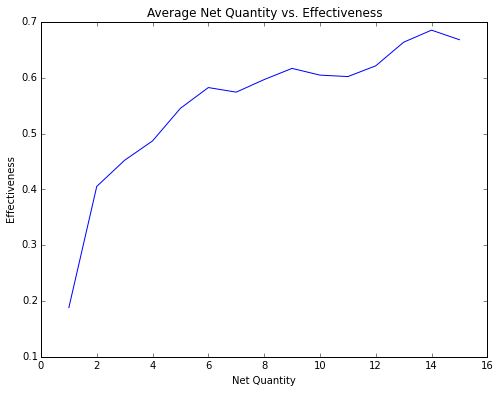

In [4]:
def create_avg_plot(dataname, smoothing=2):
    data = dataset[dataname]
    eff = dataset['Effectiveness']
    boxes = []
    if type(min(data)) == float: 
        if dataname == 'Learning Rate': boxes = np.linspace(5, 15, 11) * 0.1
        if dataname == 'Weight Decay Rate': boxes = np.linspace(0, 0.0010, 11)
    else: boxes = np.linspace(min(data), max(data), max(data) - min(data) + 1)
    
    new_boxes = []
    new_eff = []
    for i in boxes:
        tmp = [y for x, y in zip(data, eff) if x == i]
        if len(tmp) == 0: continue
        new_eff.append(sum(tmp) / float(len(tmp)))
        new_boxes.append(i)
    if len(new_eff) == 0: return
    
    new_eff_smooth = np.convolve(new_eff, np.ones(smoothing)/float(smoothing), 'same')

    plt.plot(new_boxes, new_eff_smooth)
    plt.gcf().set_size_inches(8, 6)
    plt.xlabel(dataname)
    plt.ylabel('Effectiveness')
    plt.title('Average ' + dataname + ' vs. Effectiveness')
    
interact(create_avg_plot, dataname=data_names, smoothing=(1, 10, 1));

The following two demonstrations take the highest scoring $n$ networks out of the data analysis pool and shows their average parameters. 

This lets us see where the optimal points are for network training, and more easily watch what increases and decreases as network moves. In the second plot, an approximately flat line implies that the function has little to no impact - its value remains around its average regardless of the selectivity. An increasing or a decreasing plot implies a correlation between success rate and that parameter.

In the last plot, the graph of effectiveness versus the top networks in the pool actually shows an interesting result: that if we pick random parameters on the line, we're very likely to get a final effectiveness along a linear distribution. Interestingly, most of the relationships are linear, which implies that we should prefer parameters which increase with $O(1)$ or $O(n)$ computational time complexity over those which increase with $O(n^2)$.

In [5]:
def best_setup(count):
    for name in data_names:
        print(name + ": ", float(sum(dataset[name][0:count]))/float(count))
        
interact(best_setup, count=(1, len(dataset['Effectiveness'])));

Net Quantity:  9.793333333333333
Net Keep Qty:  5.766666666666667
Learning Rate:  1.0340000000000003
Weight Decay Rate:  0.0005033333333333335
First Layer Nodes:  19.993333333333332
Second Layer Nodes:  0.0
Learning Epochs:  9.413333333333334
Training Set Size:  625.74
Training Batch Size:  4.8133333333333335
Effectiveness:  0.7349600000000001


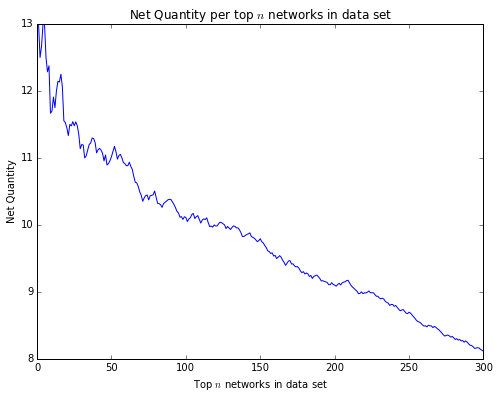

In [6]:
def best_setup_plot(dataname):
    y_data = np.array(dataset[dataname])
    y_axis = []
    for i in range(0, len(y_data)):
        var = sum(y_data[0:i+1])/float(i+1)
        y_axis.append(var)
    plt.plot(range(1, len(y_data)+1), y_axis)
    plt.xlabel("Top $n$ networks in data set")
    plt.ylabel(dataname)
    plt.title(dataname + " per top $n$ networks in data set")
    plt.gcf().set_size_inches(8, 6)

interact(best_setup_plot, dataname=data_names);